In [2]:
import pandas as pd
import numpy as np

import ipywidgets as widgets
# https://ipywidgets.readthedocs.io/en/latest/examples/Widget%20Basics.html
# https://zhuanlan.zhihu.com/p/263411257
# interactive programming package

import matplotlib.pyplot as plt
# https://matplotlib.org/stable/users/explain/interactive.html

%matplotlib inline
# How to use the magic line https://blog.csdn.net/weixin_42311095/article/details/85009922


--Special notes
pandas calculation:
use iloc[row,column] to extract the data.
--Single data point
pd.iloc[row,column].'values'

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_20344\2632306198.py:143: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  self.max_voltage.append([i,float(first_max)])


the peaks are:  [[2130, 28.35901], [2358, 21.44678], [2762, 22.39282], [3217, 22.07239], [3690, 22.11816]]
spike number 5


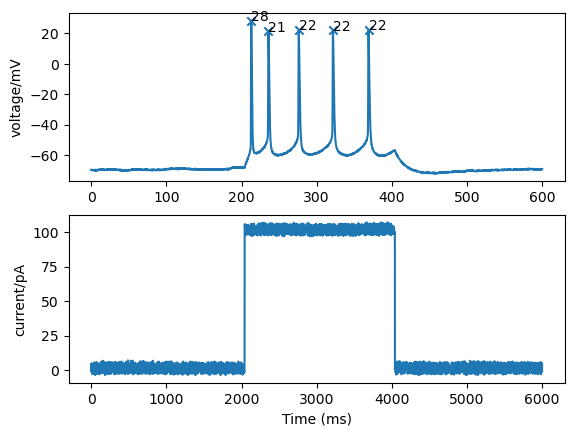

fisrt_spike_latency is -89
              file_name  spike_number      peak    minAHP  threshold  \
0  ./Data/Intact/N8.txt             1  28.35901 -58.79919  -53.53491   
1  ./Data/Intact/N8.txt             2  21.44678 -57.65479  -47.14148   
2  ./Data/Intact/N8.txt             3  22.39282 -56.47986  -46.33276   
3  ./Data/Intact/N8.txt             4  22.07239 -55.56433  -43.52515   
4  ./Data/Intact/N8.txt             5  22.11816 -55.39648  -45.29517   

   TTP-peak  TTP-AHP  amplitude   width  
0       0.7      4.8   81.89392  1.2910  
1       0.8      5.0   68.58826  1.4976  
2       0.9      5.0   68.72558  1.5239  
3       0.8      5.0   65.59754  1.5133  
4       0.9      5.0   67.41333  1.5847  


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_20344\2632306198.py:143: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  self.max_voltage.append([i,float(first_max)])


the peaks are:  [[2071, 23.742676], [2210, 20.370483], [2356, 19.760132], [2513, 19.073486], [2674, 18.371582], [2836, 18.859863], [2999, 18.463135], [3166, 18.234253], [3336, 18.630981], [3507, 18.539429], [3675, 18.615723], [3839, 17.89856]]
spike number 12


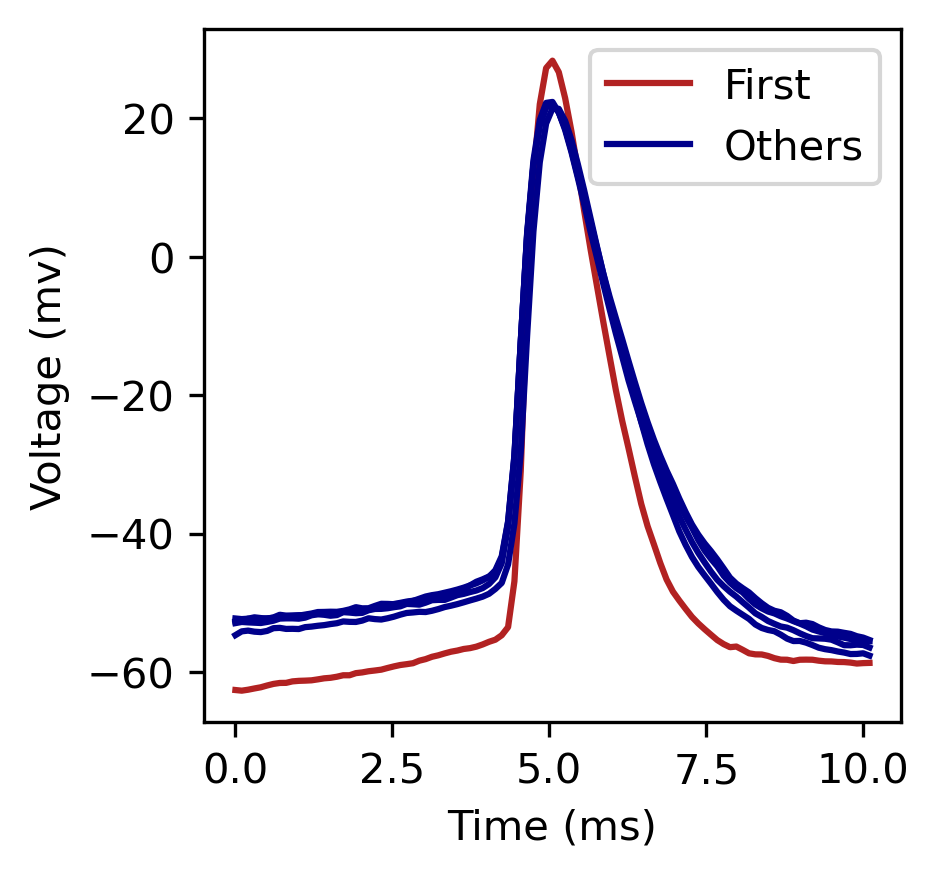

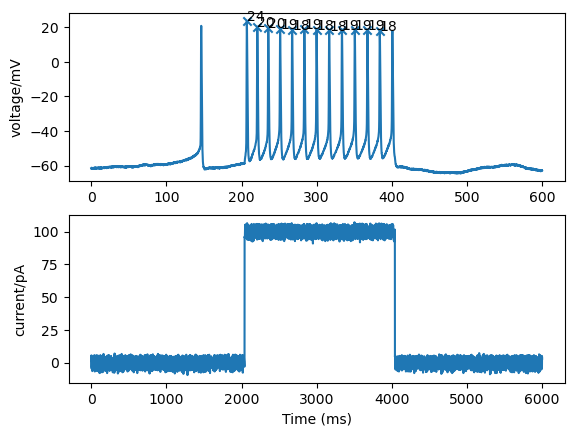

fisrt_spike_latency is -25
              file_name  spike_number       peak     minAHP  threshold  \
0   ./Data/PD/N3_PD.txt             1  23.742676 -57.449341 -49.423218   
1   ./Data/PD/N3_PD.txt             2  20.370483 -56.610107 -41.275024   
2   ./Data/PD/N3_PD.txt             3  19.760132 -56.304932 -38.665771   
3   ./Data/PD/N3_PD.txt             4  19.073486 -56.457520 -36.773682   
4   ./Data/PD/N3_PD.txt             5  18.371582 -56.213379 -37.048340   
5   ./Data/PD/N3_PD.txt             6  18.859863 -56.060791 -36.315918   
6   ./Data/PD/N3_PD.txt             7  18.463135 -55.938721 -37.170410   
7   ./Data/PD/N3_PD.txt             8  18.234253 -55.938721 -37.597656   
8   ./Data/PD/N3_PD.txt             9  18.630981 -55.999756 -35.766602   
9   ./Data/PD/N3_PD.txt            10  18.539429 -55.831909 -36.483765   
10  ./Data/PD/N3_PD.txt            11  18.615723 -56.015015 -35.812378   
11  ./Data/PD/N3_PD.txt            12  17.898560 -55.831909 -36.315918   

    TTP-pe

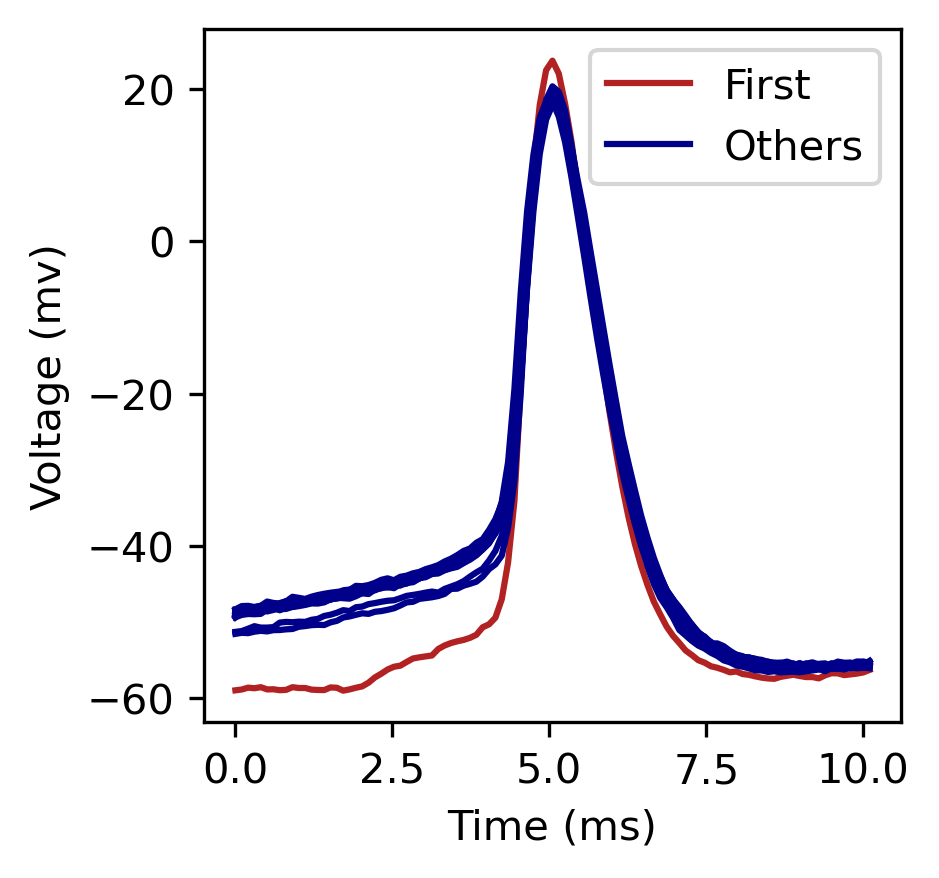

In [24]:
import pandas as pd
import numpy as np

# import ipywidgets as widgets
# https://ipywidgets.readthedocs.io/en/latest/examples/Widget%20Basics.html
# https://zhuanlan.zhihu.com/p/263411257
# interactive programming package

import matplotlib.pyplot as plt
plt.ion()
# https://matplotlib.org/stable/users/explain/interactive.html

import os
# How to use the magic line https://blog.csdn.net/weixin_42311095/article/details/85009922


class Data_Class:
    

    def __init__(self,file_path,sampling_rate):
        # set titles, data, current, voltage
        self.titles = ["current/pA","voltage/mV"]
        self.x_label = "Time (ms)"
        self.data=[]
        self.current = pd.DataFrame()
        self.voltage = pd.DataFrame() #stored in python list 1xN

        self.sampling_rate = sampling_rate
        
        self.max_voltage = []
        
        self.spike_number = 0

        self.threshold = []

        self.spike_train = pd.DataFrame()

        self.spike_features = pd.DataFrame()
        
        self.each_point = 1/self.sampling_rate*1000

        def read_data(data_path):  

            self.data = pd.read_csv(data_path,header=None,sep='\t',index_col=None)
            self.data.columns=[self.titles]
            # print the result
            # print(data.head())
            # backup plan
            # data = np.loadtxt("N1.txt")
            # df = pd.DataFrame(data=data)

            def data_to_list(data):
                '''
                pd Nx1-> list 1xN
                '''
                data.transpose()
                data = data.astype(float)
                return data
            self.file_path = file_path
            self.current = data_to_list(self.data.loc[:,self.titles[0]])
            self.voltage = data_to_list(self.data.loc[:,self.titles[1]])
        read_data(file_path)

    def main(self):
        self.find_other_maximum_points()
        self.voltage_cleaning()
        self.spike_train_extraction()
        print("spike number",self.spike_number)
        self.plot_combined_spike_and_peak()
        self.plot_action_potential()
        print("fisrt_spike_latency is",self.find_first_spike_latency())

        def find_features_in_single_spike():
            if self.spike_number == 0:
                self.spike_train_extraction()
            for i in range (self.spike_number):
                S = "S"+str(i+1)
                spike = self.extract_single_spike_data(i)
                S = Spike_Processing(spike,self.sampling_rate,self.file_path,i+1)
                feature_extracted = S.spike_processing_main()
                self.spike_features = pd.concat([self.spike_features,feature_extracted],ignore_index=True)
            return self.spike_features
        find_features = find_features_in_single_spike()
        # Testing new functions
        find_features.to_csv("find_features.csv")

    def plot_data(self):
        # fig, axs = plt.subplots(2, 1, figsize=(4, 3), layout='constrained')
        plt.subplot(211)
        plt.plot(self.current)
        # figure configuration
        # plt.xlabel(x_label)
        plt.ylabel(self.titles[0])

        plt.subplot(212)
        plt.plot(self.voltage)
        # figure configuration
        plt.xlabel(self.x_label)
        plt.ylabel(self.titles[1])
        plt.show()
    def plot_action_potential(self,title=None):
        # plot spike train data
        plt.figure("Spike_shape",dpi=300,figsize=(3,3))
        
        length = self.spike_train.__len__()
        
        x_ticks = np.linspace(0,length*self.each_point,length)
        x_ticks = pd.DataFrame(x_ticks)
        
        for i in range(self.spike_train.shape[1]):
            data = self.spike_train.iloc[:,i]
            if i==0:
                line1,=plt.plot(x_ticks,data,"firebrick")
                continue
            if title=="PD":
                line2,=plt.plot(x_ticks,data,"#1f77b4")
            elif title=="Intact":
                line2,=plt.plot(x_ticks,data,"#ff7f0e")
            else:
                line2,=plt.plot(x_ticks,data,"darkblue")
        plt.legend(handles=[line1,line2], labels=["First","Others"],loc="upper right")
        plt.xlabel("Time (ms)")
        plt.ylabel("Voltage (mv)")
        plt.title(title)
        
        

    def find_first_max_v(self,start_search=2000,comparison_interval=20):
        '''
        Using the voltage plot to find the first maximum voltage peack

        @ data: should be 1D, and should be voltage
        @ start_search: the index where search is started
        @ comparison_interval: the interval which data[i] is greater than the following data[i+1,i+comparison_interval]
        '''
        first_max = 0
        for i in range(start_search,self.voltage.__len__()):
            flag = False
            if(all(self.voltage[i+1:i+comparison_interval].values<self.voltage.iloc[i,:].values) and self.voltage.iloc[i,:].values>-15):
                first_max=self.voltage.iloc[i,:].values
                flag=True
                # print("max index",i)
                self.max_voltage.append([i,float(first_max)])
            if (flag):
                break
        # print("max voltage",first_max)
    def find_other_maximum_points(self,jump=30,end_search=4000):
        '''
        @ jump: to add some value to peak, and continue the spike finding algorithm
        '''
        if self.max_voltage == []:
            self.find_first_max_v()
        if len(self.max_voltage)<=1:
            index = self.max_voltage[0][0]
            spike_count = 1
            while index<end_search:
                len_max_voltage = len(self.max_voltage)
                self.find_first_max_v(index+jump)
                if len_max_voltage==len(self.max_voltage):
                    break
                spike_count += 1
                index = self.max_voltage[spike_count-1][0]
        else:
            pass
    def voltage_cleaning(self,removed_index_range=[3900,6000]):
        remove_index=[]
        for i in range(len(self.max_voltage)):
            if self.max_voltage[i][0]>removed_index_range[0] and self.max_voltage[i][0]<removed_index_range[1]:
                remove_index.append(i)
        remove_index.reverse()
        for j in remove_index:
            self.max_voltage.remove(self.max_voltage[j])
        print("the peaks are: ",self.max_voltage)

        self.spike_number=len(self.max_voltage)
    
    def plot_max_voltage(self):
        def extract_x_y():
            x=[]
            y=[]
            for i in range(len(self.max_voltage)):
                x.append(self.max_voltage[i][0]*self.each_point)
                y.append(self.max_voltage[i][1])
            return np.array(x),np.array(y)
        x,y=extract_x_y()
        plt.scatter(x,y,marker="x")
    def spike_extract_from_peak(self,peak_index,lower_bond=50,upper_bond=50):
        coefficient = 10000/self.sampling_rate
        lower_bond = round(lower_bond*coefficient)
        upper_bond = round(upper_bond*coefficient)
        
        spike_train = self.voltage.loc[peak_index-lower_bond:peak_index+upper_bond,:]
        #reset index
        spike_train = spike_train.reset_index(drop=True)
        return spike_train
    def spike_train_extraction(self):
        data = pd.DataFrame()
        for i in range(len(self.max_voltage)):
            peak_index=self.max_voltage[i][0]
            spike=self.spike_extract_from_peak(peak_index)
            data.insert(loc=i, column=str(i), value=spike)
        if self.spike_train.empty:
            self.spike_train = data
        return data
    def plot_combined_spike_and_peak(self):
        if self.max_voltage==[]:
            self.find_other_maximum_points()
            self.voltage_cleaning()
        # fig, axs = plt.subplots(2, 1, figsize=(4, 3), layout='constrained')
        plt.figure("Combined_spike_and_peak")
            
        plt.subplot(212)
        plt.plot(self.current)
        # figure configuration
        # plt.xlabel(x_label)
        plt.ylabel(self.titles[0])
        plt.xlabel(self.x_label)
        
        plt.subplot(211)
        
        length = self.voltage.__len__()
        x_ticks = np.linspace(0,length*self.each_point,length)
        
        plt.plot(x_ticks,self.voltage)
        # figure configuration
        
        plt.ylabel(self.titles[1])
        
    
        
        #annotation part of the data
        for i in range(len(self.max_voltage)):
            x,y=self.max_voltage[i][0]*self.each_point, self.max_voltage[i][1]
            plt.annotate(str(round(y)),xy=(x,y))
        self.plot_max_voltage()
        plt.show()

    def extract_single_spike_data(self,spike_number):
        if self.spike_train.empty:
            self.spike_train_extraction()
        data = self.spike_train.loc[:,str(spike_number)]
        return data

    def find_first_spike_latency(self):
        if self.current.empty or self.max_voltage==[]:
            self.find_other_maximum_points()
            self.voltage_cleaning()
        
        def find_voltage_max(self,current=100,error = 0.01):
            current_range = current-current*error
            for i in range(len(self.current)):
                if all(self.current.loc[i,:]>current_range):                    
                    break
            return i
        peak_idx = self.max_voltage[0][0]
        current_idx = find_voltage_max(self)
        fisrt_spike_latency = current_idx-peak_idx
        return fisrt_spike_latency

class Spike_Processing:

    def __init__(self,spike_data,sampling_rate,file_name="N1.txt",spike_number=1):
        self.features = pd.DataFrame()
        self.spike_data = spike_data
        self.features["file_name"]=[file_name]
        self.features["spike_number"]=spike_number
        self.sampling_rate = sampling_rate
    
    def spike_processing_main(self):
        self.find_peak()
        self.find_amplitude
        self.find_minAHP()
        self.find_threshold()
        self.find_time_to_peak_AHP()
        self.find_width()
        return self.features
    
    def find_peak(self):
        max = self.spike_data.max()
        maxidx = self.spike_data.idxmax()
        if "peak" not in self.features:
            self.features["peak"]=[max]
        # if "max_idx" not in self.features:
        #     self.features["max_idx"]=[maxidx]
        return max,maxidx
    
    def find_threshold(self,threshold_rate_of_change=2):
        '''
        @ The spike should be pd series: Nx1
        '''
        def find_the_rate_of_change(index):
            x1=self.spike_data.loc[index]
            x2=self.spike_data.loc[index+1]
            rate_of_change = (x2-x1)/1
            return rate_of_change
        
        max,maxidx = self.find_peak()
        for i in range(len(self.spike_data)-1):
            rate = find_the_rate_of_change(i)
            threshold = self.spike_data[i]
            threshold_idx = i
            if rate>threshold_rate_of_change: 
                if "threshold" not in self.features:
                    self.features["threshold"]=[threshold]
                    # self.features["threshold_idx"]=[threshold_idx]
                    self.features['TTP-peak']=(maxidx-i)/self.sampling_rate*1000
                return threshold,threshold_idx
            
    def find_amplitude(self):
        threshold,threshold_idx = self.find_threshold()
        max,maxidx = self.find_peak()
        amplitude = max-threshold
        if "amplitude"  not in self.features:
            self.features["amplitude"]=[amplitude]
        return amplitude

    def find_minAHP(self):
        max,maxidx = self.find_peak()
        data = self.spike_data[maxidx:]
        minAHP = data.min()
        minAHP_idx = data.idxmin()
        if "minAHP" not in self.features:
            self.features["minAHP"]=[minAHP]
        # if "minAHP_idx" not in self.features:
        #     self.features["minAHP_idx"]=[minAHP_idx]
        return minAHP, minAHP_idx

    def find_time_to_peak_AHP(self):
        # the peak means the bottom point
        max,maxidx = self.find_peak()
        minAHP,minAHP_idx = self.find_minAHP()
        time = (minAHP_idx-maxidx)/self.sampling_rate*1000
        if "TTP-AHP" not in self.features:
            self.features["TTP-AHP"]=[time]
        return time
    
    def find_width(self):
        # ISI stands for inter spike interval, which is the time between the spike to reach half amplitude
        
        def find_x(x1,y1,x2,y2,y):
            # approximate the value of t, given the x,y coordinate and the wanted x
            x = x1+ (y-y1)*(x2-x1)/(y2-y1)
            return round(x,3)

        amplitude = self.find_amplitude()
        threshold,threshold_idx = self.find_threshold()
        half_amplitude = amplitude/2+threshold
        list = []
        for i in range(len(self.spike_data)-1):
            y1 = self.spike_data[i]
            y2 = self.spike_data[i+1]
            if y1<half_amplitude<y2 or y2<half_amplitude<y1:
                x = find_x(i,y1,i+1,y2,half_amplitude)
                list.append(x)
        width = (list[1]-list[0])/self.sampling_rate*1000
        if "ISI" not in self.features:
            self.features["width"]=[width]
        return width
            

# Data viewer: Intact
N1 = Data_Class("./Data/Intact/N8.txt",10000)
N1.main()
spike_features = N1.spike_features
print(spike_features)

# Data viewer: PD  
N2 = Data_Class("./Data/PD/N3_PD.txt",10000)
N2.main()
spike_features = N2.spike_features
print(spike_features)


# For Intact
# total_features = pd.DataFrame()
# folder = "./Data/Intact"
# i=0
# for filename in os.listdir(folder):
#     i+=1 
#     filepath = folder+"/"+filename
#     N1 = Data_Class(filepath,10000)
#     N1.main()
#     spike_features = N1.spike_features
#     if total_features.empty:
#         total_features = spike_features
#         continue
#     total_features = pd.concat([total_features,spike_features],ignore_index=True)
#     total_features["Type"]="Intact"
# total_features.to_csv("../total_features_intact.csv")


# For PD
# total_features = pd.DataFrame()
# folder = "./Data/PD"
# i=0
# for filename in os.listdir(folder):
#     i+=1 
#     filepath = folder+"/"+filename
#     N1 = Data_Class(filepath,10000)
#     N1.main()
#     spike_features = N1.spike_features
#     if total_features.empty:
#         total_features = spike_features
#         continue
#     total_features = pd.concat([total_features,spike_features],ignore_index=True)
#     total_features["Type"]="PD"
# total_features.to_csv("../total_features_PD.csv")
plt.show()

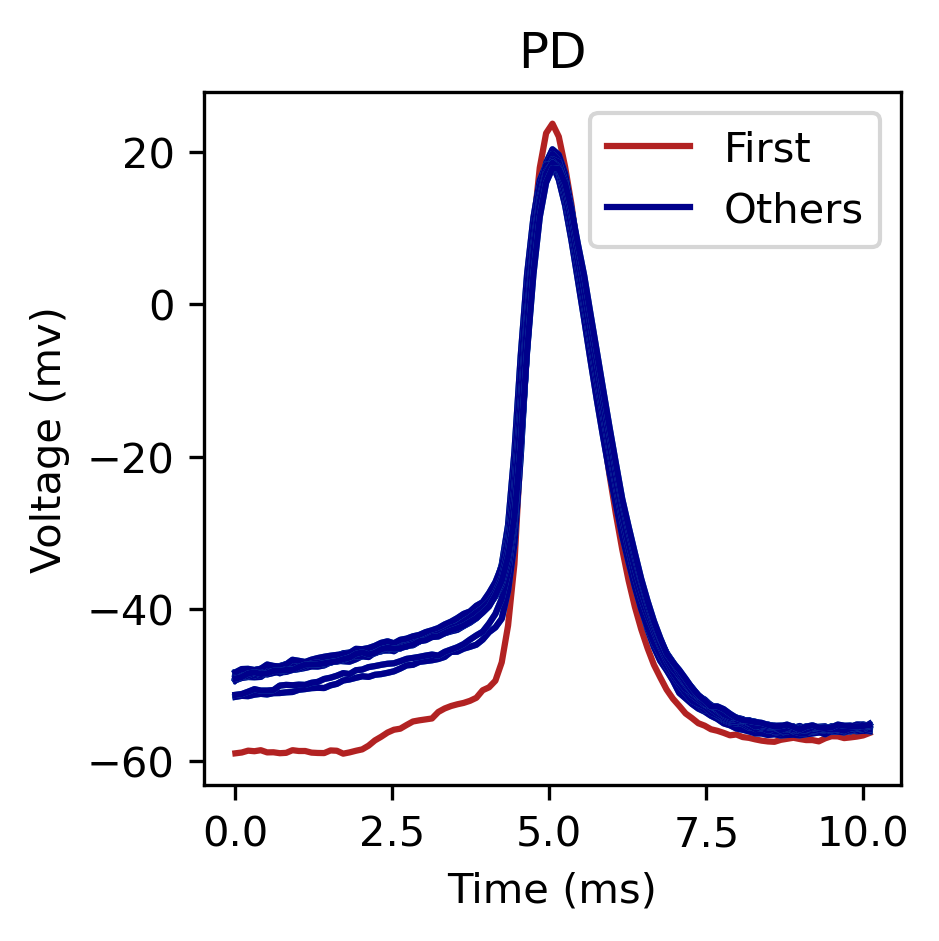

In [23]:
N2.plot_action_potential("PD")

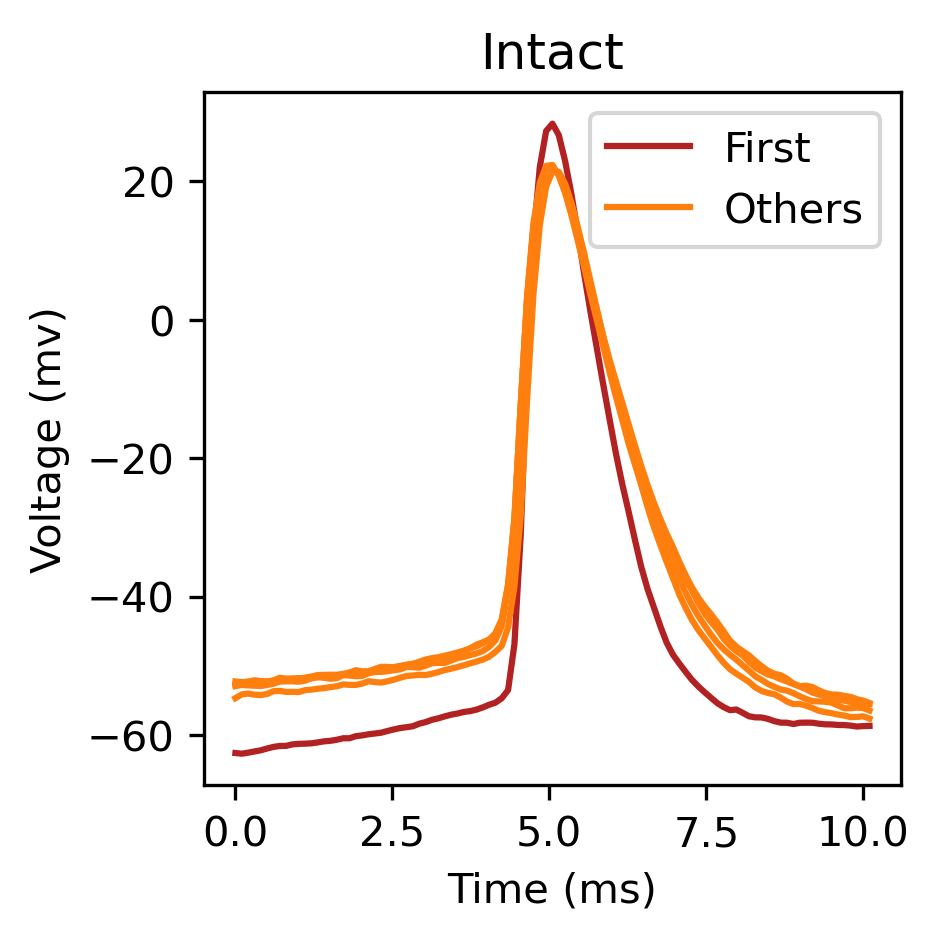

In [21]:
N1.plot_action_potential("Intact")